In [1]:
import pandas as pd                               # panda
import pandas_datareader as pdr                   # Baixar dados yahoo

import matplotlib.pyplot as plt                   # grafico
import matplotlib.dates as mdates                 # trabalhar datas

import statsmodels.api as sm                      # regressao
from statsmodels.api import add_constant          # para a regressao considerar o intercepto

import numpy as np
import scipy.stats

from statsmodels.tsa.stattools import coint       # Funcao Coint ()
from statsmodels.tsa.stattools import adfuller

# Declaracoes
pd.options.display.float_format = '{:.2f}'.format


C:\Users\paiva\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


### DECLARACAO DE FUNCOES ###

In [191]:
# Baixa base de dados e retorna uma base da forma [data,close_ativo_1, close_ativo_2]
def baixar_yahoo(tickers,inicio,fim,baixayahoo):

    # Percorre a lista tickers, lendo o yahoo e salvando no DataFrame db
    db = pd.DataFrame()
    if (baixayahoo == True):
        
        for i in tickers:
            cot = pdr.DataReader(i, 'yahoo', inicio,fim)
            cot['Ativo']=i
            db = pd.concat([db,cot],sort=True)  

        db.to_csv('Ativos.csv')
        #db.to_excel('timpedie.xlsx')
    
    db = pd.read_csv('Ativos.csv',parse_dates=[0], infer_datetime_format = True)
    #db = pd.read_excel('ITSA4GOLL4.xlsx')
    db = db[['Ativo','Date','Open','High','Low','Adj Close']].rename(columns={'Adj Close': 'Close'})    
    
    # Cria Tabela com os fechamentos dos dois ativos [DATA, Close1, Close2]
    esquerda = db[db['Ativo']==tickers[0]].set_index('Date')['Close']
    direita = db[db['Ativo']==tickers[1]].set_index('Date')['Close']
    par = pd.merge(left=esquerda, right=direita, left_on='Date', right_on='Date').rename(columns={'Close_x': tickers[0], 'Close_y': tickers[1]})

    #par.to_excel('Par.xlsx')
    
    return par



In [311]:
def regressao_univariada(x, y):
    
    # Gera a REGRESSAO LINEAR UNIVARIADA -> y = b*x + c + e
    X = sm.add_constant(x)
    res = sm.OLS(y,X).fit()
    coef_ang=res.params[1]
    residuo = par_subset[tickers[0]]-res.predict()
    zscore  = (residuo - np.mean(residuo))/np.std(residuo);
    return coef_ang, residuo, zscore 

def regressao_multivariada(x, y, periodo):

    # Gera a REGRESSAO LINEAR MULTIVARIADA (QuantGo "Simples") -> y = b*x + c*t + d + e
    X = np.column_stack((x, range(1,periodo+1,1)))
    X = sm.add_constant(X)
    #print(X)
    res = sm.OLS(y,X).fit()
    coef_ang=res.params[1]
    residuo = y-res.predict()
    zscore  = (residuo - np.mean(residuo))/np.std(residuo);
    return coef_ang, residuo, zscore 


def regressao_residuos(residuos):
     
    X = sm.add_constant(residuos.shift().fillna(method="bfill"), prepend=True)
    res = sm.OLS(-1*residuos.diff().fillna(method="bfill"),X).fit()
    #print("Regressao residuos:", dir(res))
    return res.params[1]

# ADF da Statsmodel
def adftest(df):

    adf  = adfuller(df,1)
    if   adf[0] < adf[4]['1%']:  adfc='99%'
    elif adf[0] < adf[4]['5%']:  adfc='95%'
    elif adf[0] < adf[4]['10%']: adfc='90%'
    else:                        adfc='-'                 

    return adf[0], adfc,adf[1];      

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''
    
    r, p = scipy.stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = scipy.stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    
    return r, p, lo, hi
    
def pct_financeiro(x,y,coef_ang,residuo):
    
    ultimo_x = x.tail(1)[0]
    ultimo_y = y.tail(1)[0]
    
    fin_x = ultimo_x*coef_ang
    fin_y = ultimo_y
    
    if (residuo > 0):
        compra = fin_x
        venda = fin_y
    else:
        compra = fin_y
        venda = fin_x
 
    cv = "{:.0%}".format(compra/venda)
    return cv

def calculo_meia_vida(residuo):
    # Retirado da planilha do Ferro
    coef_ang_residuos = regressao_residuos(residuo)    
    mv_beta = -1*np.log(1+coef_ang_residuos)
    meia_vida = 2/mv_beta  
    return meia_vida

def calculo_meia_vida1(residuo):
    # Retirado de um paper
    # returns the [theoretical, based on OU-process equations] number of periods to expect 
    # to have to wait for the spread to mean-revert half the distance to its mean
    price = pd.Series(residuo)  
    lagged_price = price.shift(1).fillna(method="bfill")  
    delta = price - lagged_price  
    beta = np.polyfit(lagged_price, delta, 1)[0] 
    half_life = (-1*np.log(2)/beta) 
    return half_life

In [304]:
## Funcoes graficas

def grafico_residuo(residuo):
        
    plt.figure(figsize=(20,4))
    ax = residuo.plot(color='g', grid=True, label='Z-Score')
    plt.axhline(residuo.mean(), color='red')
    plt.axhline(residuo.mean()+2*residuo.std(), color='blue')
    plt.axhline(residuo.mean()-2*residuo.std(), color='blue')

    ax.xaxis_date()  # formata o timestamp para o formato data
    ax.set_axisbelow(True)
    ax.set_title('Residuos', color='black')
    ax.set_facecolor('white')
    ax.figure.set_facecolor('white')

    plt.legend()
    plt.show()    
        

In [310]:

tickers = ['ITSA4.SA','GOLL4.SA'];

# Busca cotacoes no Yahoo Finance
par = baixar_yahoo(tickers, '2019-1-1','2020-7-28',True)
par['ratio']=par[tickers[0]]/par[tickers[1]]
print(par)
# Cria o cubo de periodos
cubo = pd.DataFrame(columns=['Periodo','Dickey_Fuller','ADF','Coef_Ang','QTD_Desvios','Fisher_min','Fisher_max'
                             ,'ADF_pvalue','pct_fin','meia_vida','Reg_Univar'
                             ,#'coint_p', 'coint_dickey','coint_adf'
                            ])

# Popula o cubo de periodos
#for i in range(100,260,10):
for i in [100,120,140,160,180,200,220,240,250]:
 
    # Cria subset do tamanho do periodo atual da iteração e seta a variavel indep (x) e dependente (y)
    par_subset = par.tail(i)
    x = par_subset[tickers[1]]
    y = par_subset[tickers[0]]
    
    # Adiciona o PERIODO analisado no dataframe
    cubo = cubo.append({'Periodo': int(i)}, ignore_index=True)
    
    # Gera a REGRESSAO e retorna o Coef Ang, e o z-score
    coef_ang, residuo, zscore    = regressao_multivariada(x, y, i)
    coef_ang1, residuo1, zscore1 = regressao_univariada(x, y)  # Apenas para comparacao

    # Teste de Estacionariedade dos Resíduos (ADF)
    adfstat,adfc,adfpvalue = adftest(residuo)
 
    # Calculo do Fisher
    ficher_r, fisher_pvalue, fisher_lo, fisher_hi = pearsonr_ci(x.pct_change().fillna(method="bfill"),
                                                                y.pct_change().fillna(method="bfill"))
    
    # Calculo do % Financeiro (C/V)
    pct_fin = pct_financeiro(x,y,coef_ang, zscore.tail(1).values)
    
    # Calculo da Meia-vida - ORNSTEIN-UHLENBECK
    meia_vida = calculo_meia_vida(residuo)
    
    # Preenchimento do cubo
    cubo.loc[cubo['Periodo']==i, 'Coef_Ang']      = coef_ang 
    cubo.loc[cubo['Periodo']==i, 'QTD_Desvios']   = zscore.tail(1)[0]
    cubo.loc[cubo['Periodo']==i, 'Dickey_Fuller'] = adfstat
    cubo.loc[cubo['Periodo']==i, 'ADF']           = adfc 
    cubo.loc[cubo['Periodo']==i, 'ADF_pvalue']    = adfpvalue 
    cubo.loc[cubo['Periodo']==i, 'Fisher_min']    = fisher_lo
    cubo.loc[cubo['Periodo']==i, 'Fisher_max']    = fisher_hi
    cubo.loc[cubo['Periodo']==i, 'pct_fin']       = pct_fin
    cubo.loc[cubo['Periodo']==i, 'meia_vida']     = meia_vida
    cubo.loc[cubo['Periodo']==i, 'Reg_Univar']    = coef_ang1 

    # Coint - apenas para comparacao
    #score, pvalue, _ = coint(residuo[1:],residuo.diff()[1:], maxlag=1, autolag='t-stat')

    #if (score < _[0]): coint_adf='99%'
    #elif (score < _[1]): coint_adf='95%'
    #elif (score < _[2]): coint_adf='90%'
    #else: coint_adf='0%'
    #cubo.loc[cubo['Periodo']==i, 'coint_dickey']    = score
    #cubo.loc[cubo['Periodo']==i, 'coint_p']       = pvalue
    #cubo.loc[cubo['Periodo']==i, 'coint_adf']     = coint_adf
    
#par.to_excel("Par.xlsx")    
display(cubo)

# Desvio médio do Coef. Angular - apenas dos periodos cointegrados
cubo_cointegrado = cubo.loc[cubo['ADF'] != '0%']
print("Desvio Medio do Coef. Angular: {:.2%}" .format(cubo_cointegrado['Coef_Ang'].std()/cubo_cointegrado['Coef_Ang'].mean()))



            ITSA4.SA  GOLL4.SA  ratio
Date                                 
2019-01-02     11.57     25.45   0.45
2019-01-03     11.67     25.63   0.46
2019-01-04     11.64     25.00   0.47
2019-01-07     11.63     23.90   0.49
2019-01-08     11.78     23.59   0.50
...              ...       ...    ...
2020-07-21     10.52     20.66   0.51
2020-07-22     10.52     20.00   0.53
2020-07-23     10.37     19.10   0.54
2020-07-24     10.51     18.73   0.56
2020-07-27     11.02     18.52   0.60

[388 rows x 3 columns]


,Periodo,Dickey_Fuller,ADF,Coef_Ang,QTD_Desvios,Fisher_min,Fisher_max,ADF_pvalue,pct_fin,meia_vida,Reg_Univar
0,100.00,-2.70,90%,0.21,3.37,0.54,0.76,0.07,36%,-11.68,0.16
1,120.00,-2.67,90%,0.16,2.82,0.56,0.76,0.08,27%,-15.15,0.17
2,140.00,-3.03,95%,0.16,2.89,0.57,0.75,0.03,26%,-15.66,0.17
3,160.00,-3.09,95%,0.16,3.07,0.57,0.74,0.03,27%,-15.18,0.18
4,180.00,-3.37,95%,0.16,3.26,0.57,0.73,0.01,27%,-14.70,0.18
5,200.00,-3.43,95%,0.16,2.62,0.57,0.73,0.01,27%,-17.40,0.18
6,220.00,-3.88,99%,0.16,2.59,0.56,0.72,0.00,28%,-15.01,0.18
7,240.00,-3.72,99%,0.17,1.70,0.57,0.71,0.00,29%,-21.47,0.17
8,250.00,-3.05,95%,0.17,1.22,0.56,0.71,0.03,29%,-30.43,0.16


Desvio Medio do Coef. Angular: 10.28%


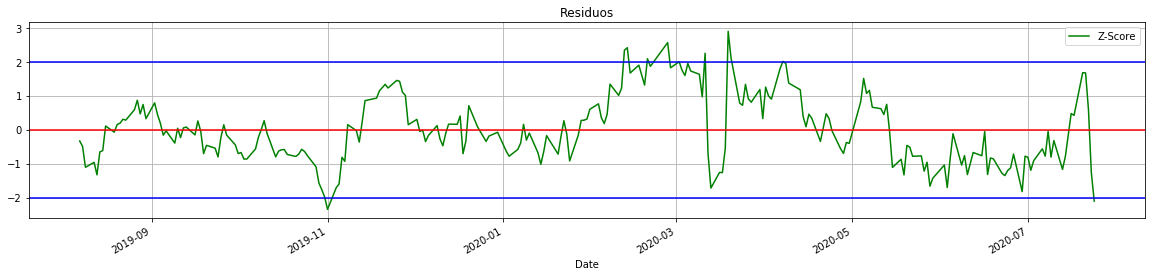

Date
2019-08-07   -0.33
2019-08-08   -0.49
2019-08-09   -1.10
2019-08-12   -0.96
2019-08-13   -1.33
              ... 
2020-07-20    1.68
2020-07-21    1.67
2020-07-22    0.60
2020-07-23   -1.26
2020-07-24   -2.10
Name: TIMP3.SA, Length: 240, dtype: float64


In [309]:
# Gera os graficos do Desvio para o periodo selecionado

##### Substituir pelo periodo que quer analisar  ######
periodo = 240;
##### Substituir pelo periodo que quer analisar  ######
        
coef_ang, residuo, zscore = regressao_multivariada(par[tickers[1]].tail(periodo), par[tickers[0]].tail(periodo),periodo)
grafico_residuo(zscore)
print(zscore)